In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

### Load H36M

In [26]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [2]:
from lib.utils.tools import * # get_config
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.dataset_motion_3d import MotionDataset3D

opts = parse_args_by_model_name(target='MB_ft_h36m')
args = get_config(opts.config)
print(opts.evaluate, args.model, args.subset_list)

args.dt_file = 'h36m_sh_s1.pkl' # 'h36m_sh_with_no_factor.pkl'
args.subset_list = ['H36M-SH_S1_WITH_NO_FACTOR']
datareader = DataReaderH36M(n_frames=args.clip_len, 
                            sample_stride=args.sample_stride, 
                            data_stride_train=args.data_stride, 
                            data_stride_test=args.clip_len, 
                            dt_root = 'data/motion3d', 
                            dt_file=args.dt_file)

args.batch_size = 2
print('Loading dataset...')
trainloader_params = {
        'batch_size': args.batch_size,
        'shuffle': True,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
train_dataset = MotionDataset3D(args, args.subset_list, 'train')
train_loader = DataLoader(train_dataset, **trainloader_params)
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
test_loader = DataLoader(test_dataset, **testloader_params)

checkpoint/pose3d/MB_ft_h36m/best_epoch.bin MB ['H36M-SH']
Loading dataset...


In [4]:
for idx, (batch_input, batch_gt) in tqdm(enumerate(train_loader)):    
    batch_size = len(batch_input)        
    if torch.cuda.is_available():
        batch_input = batch_input.cuda()
        batch_gt = batch_gt.cuda()
    break

0it [00:01, ?it/s]


In [5]:
batch_input.shape, batch_gt.shape

(torch.Size([2, 243, 17, 3]), torch.Size([2, 243, 17, 3]))

### Load pkl

In [27]:
for item in glob('/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl' + '/*'):
    print(item)
    data = readpkl(item)
    break

/home/hrai/codes/MotionBERT/data/motion3d/h36m_train_pkl/S1_54138969_Walking.pkl


In [28]:
data.keys()

dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param'])

In [39]:
joint_2d = normalize_input(np.array(data['joint_2d']), W=1000, H=1000) 
joint_3d = np.array(data['world_3d']) # /1000
batch_input = torch.from_numpy(joint_2d).float().unsqueeze(0)
batch_gt = torch.from_numpy(joint_3d).float().unsqueeze(0)
batch_input.shape, batch_gt.shape

(torch.Size([1, 3134, 17, 2]), torch.Size([1, 3134, 17, 3]))

### Extract upper limb data

#### Input

In [41]:
# get the keypoint index
r_hip = get_h36m_keypoint_index('r_hip')
l_hip = get_h36m_keypoint_index('l_hip')
r_shoulder = get_h36m_keypoint_index('r_shoulder')
l_shoulder = get_h36m_keypoint_index('l_shoulder')
r_elbow = get_h36m_keypoint_index('r_elbow')
l_elbow = get_h36m_keypoint_index('l_elbow')
r_knee = get_h36m_keypoint_index('r_knee')
l_knee = get_h36m_keypoint_index('l_knee')

In [42]:
# 2D p1, p2
p1_r_hip = batch_input[:, :, r_hip, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])
p1_l_hip = batch_input[:, :, l_hip, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])
p1_r_shoulder = batch_input[:, :, r_shoulder, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])
p1_l_shoulder = batch_input[:, :, l_shoulder, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])
p2_r_elbow = batch_input[:, :, r_elbow, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])
p2_l_elbow = batch_input[:, :, l_elbow, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])
p2_r_knee = batch_input[:, :, r_knee, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])
p2_l_knee = batch_input[:, :, l_knee, :2].unsqueeze(2) # torch.Size([1, 243, 1, 2])

# 2D vector
v_r_upper_leg = p2_r_knee - p1_r_hip # torch.Size([1, 243, 1, 2])
v_l_upper_leg = p2_l_knee - p1_l_hip # torch.Size([1, 243, 1, 2])
v_r_upper_arm = p2_r_elbow - p1_r_shoulder # torch.Size([1, 243, 1, 2])
v_l_upper_arm = p2_l_elbow - p1_l_shoulder # torch.Size([1, 243, 1, 2])

# input
input_r_upper_leg = torch.cat([p1_r_hip, v_r_upper_leg], dim=2)
input_l_upper_leg = torch.cat([p1_l_hip, v_l_upper_leg], dim=2)
input_r_upper_arm = torch.cat([p1_r_shoulder, v_r_upper_arm], dim=2)
input_l_upper_arm = torch.cat([p1_l_shoulder, v_l_upper_arm], dim=2)

In [43]:
p1_r_hip.shape, v_r_upper_leg.shape, v_l_upper_leg.shape, v_r_upper_arm.shape, v_l_upper_arm.shape

(torch.Size([1, 3134, 1, 2]),
 torch.Size([1, 3134, 1, 2]),
 torch.Size([1, 3134, 1, 2]),
 torch.Size([1, 3134, 1, 2]),
 torch.Size([1, 3134, 1, 2]))

#### GT

In [44]:
# 3D d1, d2
d1_r_hip = batch_gt[:, :, r_hip].unsqueeze(2) # torch.Size([1, F, 1, 3])
d1_l_hip = batch_gt[:, :, l_hip].unsqueeze(2) # torch.Size([1, F, 1, 3])
d1_r_shoulder = batch_gt[:, :, r_shoulder].unsqueeze(2) # torch.Size([1, F, 1, 3])
d1_l_shoulder = batch_gt[:, :, l_shoulder].unsqueeze(2) # torch.Size([1, F, 1, 3])
d2_r_knee = batch_gt[:, :, r_knee].unsqueeze(2) # torch.Size([1, F, 1, 3])
d2_l_knee = batch_gt[:, :, l_knee].unsqueeze(2) # torch.Size([1, F, 1, 3])
d2_r_elbow = batch_gt[:, :, r_elbow].unsqueeze(2) # torch.Size([1, F, 1, 3])
d2_l_elbow = batch_gt[:, :, l_elbow].unsqueeze(2) # torch.Size([1, F, 1, 3])

# 3D vector
k_r_upper_leg = d2_r_knee - d1_r_hip # torch.Size([1, F, 1, 3])
k_l_upper_leg = d2_l_knee - d1_l_hip # torch.Size([1, F, 1, 3])
k_r_upper_arm = d2_r_elbow - d1_r_shoulder # torch.Size([1, F, 1, 3])
k_l_upper_arm = d2_l_elbow - d1_l_shoulder # torch.Size([1, F, 1, 3])

# Azimuth, Elevation angle
R_azim_r_upper_leg, R_elev_r_upper_leg = calculate_batch_azimuth_elevation(k_r_upper_leg[:, :, 0]) # torch.Size([1, F])
R_azim_l_upper_leg, R_elev_l_upper_leg = calculate_batch_azimuth_elevation(k_l_upper_leg[:, :, 0]) # torch.Size([1, F])
R_azim_r_upper_arm, R_elev_r_upper_arm = calculate_batch_azimuth_elevation(k_r_upper_arm[:, :, 0]) # torch.Size([1, F])
R_azim_l_upper_arm, R_elev_l_upper_arm = calculate_batch_azimuth_elevation(k_l_upper_arm[:, :, 0]) # torch.Size([1, F])

R_r_upper_leg = torch.cat([R_azim_r_upper_leg.unsqueeze(-1), R_elev_r_upper_leg.unsqueeze(-1)], dim=-1) # torch.Size([1, F, 2])
R_l_upper_leg = torch.cat([R_azim_l_upper_leg.unsqueeze(-1), R_elev_l_upper_leg.unsqueeze(-1)], dim=-1) # torch.Size([1, F, 2])
R_r_upper_arm = torch.cat([R_azim_r_upper_arm.unsqueeze(-1), R_elev_r_upper_arm.unsqueeze(-1)], dim=-1) # torch.Size([1, F, 2])
R_l_upper_arm = torch.cat([R_azim_l_upper_arm.unsqueeze(-1), R_elev_l_upper_arm.unsqueeze(-1)], dim=-1) # torch.Size([1, F, 2])

# Bone length
L_r_upper_leg = torch.mean(torch.norm(k_r_upper_leg, dim=-1), dim=1, keepdim=True) # torch.Size([1, 1])
L_l_upper_leg = torch.mean(torch.norm(k_l_upper_leg, dim=-1), dim=1, keepdim=True) # torch.Size([1, 1])
L_r_upper_arm = torch.mean(torch.norm(k_r_upper_arm, dim=-1), dim=1, keepdim=True) # torch.Size([1, 1])
L_l_upper_arm = torch.mean(torch.norm(k_l_upper_arm, dim=-1), dim=1, keepdim=True) # torch.Size([1, 1])

In [45]:
R_azim_r_upper_leg.shape, R_elev_r_upper_leg.shape, L_r_upper_leg.shape, d1_r_hip[:, : , 0].shape

(torch.Size([1, 3134]),
 torch.Size([1, 3134]),
 torch.Size([1, 1, 1]),
 torch.Size([1, 3134, 3]))

In [46]:
d2_r_knee_recovered.shape, d2_r_knee.shape

(torch.Size([1, 3134, 3]), torch.Size([1, 3134, 1, 3]))

In [47]:
# check length and angles
d2_r_knee_recovered = batch_azim_elev_to_vec(R_azim_r_upper_leg, R_elev_r_upper_leg, L_r_upper_leg, d1_r_hip[:, : , 0])
(d2_r_knee_recovered - d2_r_knee[:, :, 0]).mean()

tensor(1.9802e-08)

#### Check extracted data

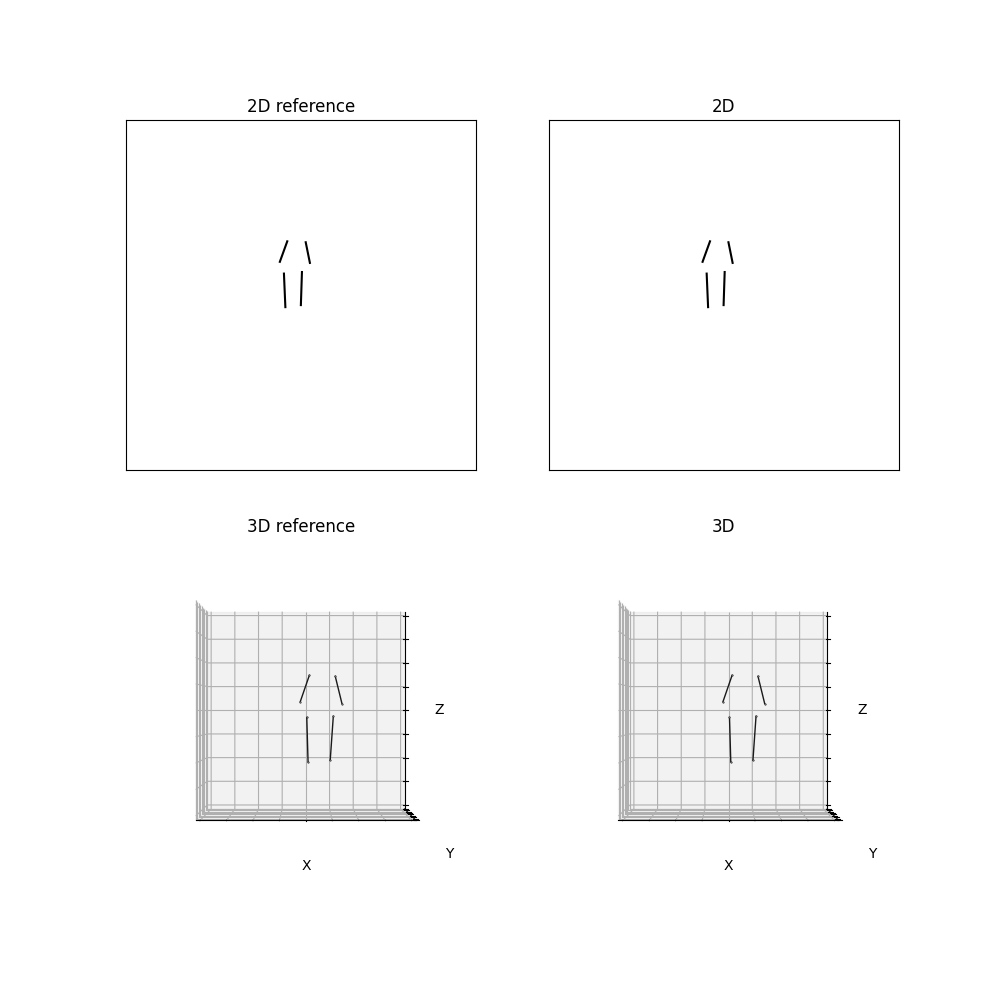

In [55]:
batch_num = 0
frame_num = 0
vec_2d_r_upper_leg_ref = torch.cat([p1_r_hip, p2_r_knee], dim=2)
vec_2d_l_upper_leg_ref = torch.cat([p1_l_hip, p2_l_knee], dim=2)
vec_2d_r_upper_arm_ref = torch.cat([p1_r_shoulder, p2_r_elbow], dim=2)
vec_2d_l_upper_arm_ref = torch.cat([p1_l_shoulder, p2_l_elbow], dim=2)

vec_2d_r_upper_leg = torch.cat([p1_r_hip, p1_r_hip + v_r_upper_leg], dim=2)
vec_2d_l_upper_leg = torch.cat([p1_l_hip, p1_l_hip + v_l_upper_leg], dim=2)
vec_2d_r_upper_arm = torch.cat([p1_r_shoulder, p1_r_shoulder + v_r_upper_arm], dim=2)
vec_2d_l_upper_arm = torch.cat([p1_l_shoulder, p1_l_shoulder + v_l_upper_arm], dim=2)

vec_3d_r_upper_leg_ref = torch.cat([d1_r_hip, d2_r_knee], dim=2)
vec_3d_l_upper_leg_ref = torch.cat([d1_l_hip, d2_l_knee], dim=2)
vec_3d_r_upper_arm_ref = torch.cat([d1_r_shoulder, d2_r_elbow], dim=2)
vec_3d_l_upper_arm_ref = torch.cat([d1_l_shoulder, d2_l_elbow], dim=2)

vec_3d_r_upper_leg = torch.cat([d1_r_hip, d1_r_hip + k_r_upper_leg], dim=2)
vec_3d_l_upper_leg = torch.cat([d1_l_hip, d1_l_hip + k_l_upper_leg], dim=2)
vec_3d_r_upper_arm = torch.cat([d1_r_shoulder, d1_r_shoulder + k_r_upper_arm], dim=2)
vec_3d_l_upper_arm = torch.cat([d1_l_shoulder, d1_l_shoulder + k_l_upper_arm], dim=2)
#print(vector.shape)

%matplotlib widget
fig = plt.figure(0, figsize=(10, 10))
fig.clear()
fig.tight_layout()
ax_ref = axes_2d(fig, loc=221, normalize=True, show_axis=False)
ax = axes_2d(fig, loc=222, normalize=True, show_axis=False)
ax_3d_ref = axes_3d(fig, loc=223, show_axis=False, xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(0, 90)) #  view=(-90, -90))
ax_3d = axes_3d(fig, loc=224, show_axis=False, xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(0, 90)) 
ax_ref.set_title('2D reference')
ax.set_title('2D')
ax_3d_ref.set_title('3D reference')
ax_3d.set_title('3D')

draw_2d_pose(ax_ref, vec_2d_r_upper_leg_ref[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')
draw_2d_pose(ax_ref, vec_2d_l_upper_leg_ref[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')
draw_2d_pose(ax_ref, vec_2d_r_upper_arm_ref[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')
draw_2d_pose(ax_ref, vec_2d_l_upper_arm_ref[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')
draw_2d_pose(ax, vec_2d_r_upper_leg[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')
draw_2d_pose(ax, vec_2d_l_upper_leg[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')
draw_2d_pose(ax, vec_2d_r_upper_arm[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')
draw_2d_pose(ax, vec_2d_l_upper_arm[batch_num, frame_num].cpu().numpy(), normalize=True, dataset='vector')

draw_3d_pose(ax_3d_ref, vec_3d_r_upper_leg_ref[batch_num, frame_num].cpu().numpy(), dataset='vector')
draw_3d_pose(ax_3d_ref, vec_3d_l_upper_leg_ref[batch_num, frame_num].cpu().numpy(), dataset='vector')
draw_3d_pose(ax_3d_ref, vec_3d_r_upper_arm_ref[batch_num, frame_num].cpu().numpy(), dataset='vector')
draw_3d_pose(ax_3d_ref, vec_3d_l_upper_arm_ref[batch_num, frame_num].cpu().numpy(), dataset='vector')
draw_3d_pose(ax_3d, vec_3d_r_upper_leg[batch_num, frame_num].cpu().numpy(), dataset='vector')
draw_3d_pose(ax_3d, vec_3d_l_upper_leg[batch_num, frame_num].cpu().numpy(), dataset='vector')
draw_3d_pose(ax_3d, vec_3d_r_upper_arm[batch_num, frame_num].cpu().numpy(), dataset='vector')
draw_3d_pose(ax_3d, vec_3d_l_upper_arm[batch_num, frame_num].cpu().numpy(), dataset='vector')
plt.show()

100%|██████████| 243/243 [00:06<00:00, 36.93it/s]


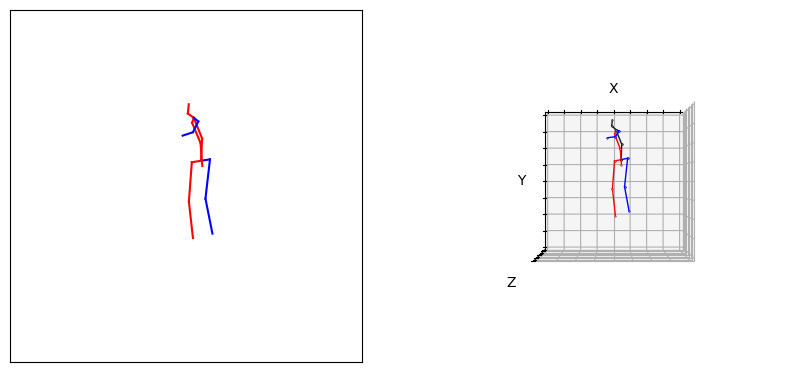

In [46]:
fig = plt.figure(1, figsize=(10, 10))
fig.clear()
ax_2d = axes_2d(fig, loc=121, normalize=True, show_axis=False)
ax_3d = axes_3d(fig, loc=122, show_axis=False, xlim=(-1, 1), ylim=(-1, 1), view=(-90, -90))
videowriter = imageio.get_writer('h36m_no_factor_test_batch0.mp4', fps=30)
for i in tqdm(range(243)):
    clear_axes([ax_2d, ax_3d])
    draw_2d_pose(ax_2d, batch_input[0, i].cpu().numpy(), normalize=True)
    draw_3d_pose(ax_3d, batch_gt[0, i].cpu().numpy())
    
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
    videowriter.append_data(image_from_plot)
videowriter.close()
        

### build batch input, gt

In [9]:
input, gt_root_point, gt_length, gt_angle = get_input_gt_for_onevec(batch_input, batch_gt)
input.shape, gt_root_point.shape, gt_length.shape, gt_angle.shape

(torch.Size([8, 243, 2, 2]),
 torch.Size([8, 243, 3]),
 torch.Size([8, 1]),
 torch.Size([8, 243, 2]))

### Model test

In [3]:
from lib.model.DHDSTformer import DHDSTformer_onevec
from lib.utils.tools import * # get_config

target_model = 'DHDST_onevec_h36m_s1_baseline'
opts = parse_args_by_model_name(target=target_model)
args = get_config(opts.config)
print(opts.evaluate, args.model)

model_pos = DHDSTformer_onevec(args)
chk_filename = opts.evaluate
print('Loading checkpoint', chk_filename)
checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
model_pos.load_state_dict(checkpoint['model_pos'], strict=False)

model_pos = model_pos.cuda()
model_pos = model_pos.eval()

checkpoint/pose3d/DHDST_onevec_h36m_s1_baseline/best_epoch.bin DHDST_onevec
Loading checkpoint checkpoint/pose3d/DHDST_onevec_h36m_s1_baseline/best_epoch.bin


In [4]:
gts_all_root_point = []
gts_all_child_point = []
gts_all_3d_pos = []
gts_all_length = []
gts_all_angle = []
gts_all_child_point = []
results_all_root_point = []
results_all_child_point = []
results_all_3d_pos = []
results_all_length = []
results_all_angle = []
results_all_child_point = []
num_test_frames = 0 
with torch.no_grad():
    for idx, (batch_input, batch_gt) in tqdm(enumerate(test_loader)):  
        batch_size = len(batch_input)    
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
            batch_gt = batch_gt.cuda()
            
        # inference
        input, gt_root_point, gt_length, gt_angle = get_input_gt_for_onevec(batch_input, batch_gt)
        pred_root_point, pred_length, pred_angle = model_pos(input)
        
        num_test_frames += input.shape[0] * input.shape[1]

        gt_R_azim = gt_angle[:, :, 0] # torch.Size([B, F])
        gt_R_elev = gt_angle[:, :, 1] # torch.Size([B, F])
        pred_R_azim = pred_angle[:, :, 0] # torch.Size([B, F])
        pred_R_elev = pred_angle[:, :, 1] # torch.Size([B, F])
        gt_child_point = batch_azim_elev_to_vec(gt_R_azim, gt_R_elev, gt_length, gt_root_point) # torch.Size([B, F, 3])
        pred_child_point = batch_azim_elev_to_vec(pred_R_azim, pred_R_elev, pred_length, pred_root_point) # torch.Size([B, F, 3])
        gt_3d_pos = torch.cat([gt_root_point.unsqueeze(2), gt_child_point.unsqueeze(2)], dim=2) # torch.Size([B, F, 2, 3])
        pred_3d_pos = torch.cat([pred_root_point.unsqueeze(2), pred_child_point.unsqueeze(2)], dim=2) # torch.Size([B, F, 2, 3])
        
        results_all_root_point.append(pred_root_point.cpu().numpy())
        results_all_child_point.append(pred_child_point.cpu().numpy())
        results_all_3d_pos.append(pred_3d_pos.cpu().numpy())
        results_all_length.append(pred_length.cpu().numpy())
        results_all_angle.append(pred_angle.cpu().numpy())
        gts_all_root_point.append(gt_root_point.cpu().numpy())
        gts_all_child_point.append(gt_child_point.cpu().numpy())
        gts_all_3d_pos.append(gt_3d_pos.cpu().numpy())
        gts_all_length.append(gt_length.cpu().numpy())
        gts_all_angle.append(gt_angle.cpu().numpy())

results_all_root_point = np.concatenate(results_all_root_point)
results_all_child_point = np.concatenate(results_all_child_point)
results_all_3d_pos = np.concatenate(results_all_3d_pos)
results_all_length = np.concatenate(results_all_length)
results_all_angle = np.concatenate(results_all_angle)
gts_all_root_point = np.concatenate(gts_all_root_point)
gts_all_child_point = np.concatenate(gts_all_child_point)
gts_all_3d_pos = np.concatenate(gts_all_3d_pos)
gts_all_length = np.concatenate(gts_all_length)
gts_all_angle = np.concatenate(gts_all_angle)

480it [00:04, 102.12it/s]


In [5]:
results_all_root_point.shape

(3840, 243, 3)

In [6]:
num_test_frames

933120

In [7]:
results_r_upper_leg_root_point = results_all_root_point[0::4]
results_r_upper_leg_child_point = results_all_child_point[0::4]
results_r_upper_leg_3d_pos = results_all_3d_pos[0::4]
results_r_upper_leg_length = results_all_length[0::4]
results_r_upper_leg_angle = results_all_angle[0::4]

results_l_upper_leg_root_point = results_all_root_point[1::4]
results_r_upper_arm_root_point = results_all_root_point[2::4]
results_l_upper_arm_root_point = results_all_root_point[3::4]

In [8]:
num_test_frames = int(num_test_frames/4)

In [9]:
action_names = sorted(set(datareader.dt_dataset['test']['action']))
part_list = ['whole', 'r_hip', 'l_hip', 'r_knee', 'l_knee', 'r_shoulder', 'l_shoulder', 'r_elbow', 'l_elbow', 'r_upper_leg', 'l_upper_leg', 'r_upper_arm', 'l_upper_arm']
eval_part = 'whole'

total_result_dict = {}
for part in part_list:
    total_result_dict[part] = {
        'e1_all': np.zeros(num_test_frames),
        'e2_all': np.zeros(num_test_frames),
        'oc': np.zeros(num_test_frames),
        'results': {},
        'results_procrustes': {}
    }
    
    # To classify the results by action
    for action in action_names:
        total_result_dict[part]['results'][action] = []
        total_result_dict[part]['results_procrustes'][action] = []

In [10]:
total_result_dict.keys()

dict_keys(['whole', 'r_hip', 'l_hip', 'r_knee', 'l_knee', 'r_shoulder', 'l_shoulder', 'r_elbow', 'l_elbow', 'r_upper_leg', 'l_upper_leg', 'r_upper_arm', 'l_upper_arm'])

In [11]:
results_all_root_point.shape

(3840, 243, 3)

In [12]:
from lib.model.loss import *


for idx in tqdm(range(len(results_all_root_point))):
    #print(idx)
    pred_root_point = results_all_root_point[idx] # torch.Size([F, 3])
    pred_child_point = results_all_child_point[idx] # torch.Size([F, 3])
    pred_3d_pos = results_all_3d_pos[idx] # torch.Size([F, 2, 3])
    pred_length = results_all_length[idx] # torch.Size([1])
    pred_angle = results_all_angle[idx] # torch.Size([F, 2])
    gt_root_point = gts_all_root_point[idx] # torch.Size([F, 3])
    gt_child_point = gts_all_child_point[idx] # torch.Size([F, 3])
    gt_3d_pos = gts_all_3d_pos[idx] # torch.Size([F, 2, 3])
    gt_length = gts_all_length[idx] # torch.Size([1])
    gt_angle = gts_all_angle[idx] # torch.Size([F, 2])
    
    err1_per_joint = mpjpe_for_each_joint(gt_3d_pos, pred_3d_pos) * 1000 # (F, J)
    err2_per_joint = p_mpjpe_for_each_joint(gt_3d_pos, pred_3d_pos) * 1000 # (F, J)
    #print(err1_per_joint.shape, err2_per_joint.shape)
    
    if idx%4 == 0: part = 'r_upper_leg'
    elif idx%4 == 1: part = 'l_upper_leg'
    elif idx%4 == 2: part = 'r_upper_arm'
    elif idx%4 == 3: part = 'l_upper_arm'
    
    frame_list = list(range((idx//4)*args.clip_len, ((idx//4)+1)*args.clip_len))
    total_result_dict[part]['e1_all'][frame_list] = np.mean(err1_per_joint, axis=1) # (243, ) # 각 프레임 별 에러를 평균
    total_result_dict[part]['e2_all'][frame_list] = np.mean(err2_per_joint, axis=1) # (243, ) # 각 프레임 별 에러를 평균
    total_result_dict[part]['oc'][frame_list] = 1
    
    for J in range(err1_per_joint.shape[1]):
        if part == 'r_upper_leg':
            if J == 0: subpart = 'r_hip'
            elif J == 1: subpart = 'r_knee'
        elif part == 'l_upper_leg':
            if J == 0: subpart = 'l_hip'
            elif J == 1: subpart = 'l_knee'
        elif part == 'r_upper_arm':
            if J == 0: subpart = 'r_shoulder'
            elif J == 1: subpart = 'r_elbow'
        elif part == 'l_upper_arm':
            if J == 0: subpart = 'l_shoulder'
            elif J == 1: subpart = 'l_elbow'
        
        total_result_dict[subpart]['e1_all'][frame_list] += err1_per_joint[:, J] # (243, ) # 각 프레임 별 에러를 더해줌
        total_result_dict[subpart]['e2_all'][frame_list] += err2_per_joint[:, J] # (243, ) # 각 프레임 별 에러를 더해줌
        total_result_dict[subpart]['oc'][frame_list] += 1
        
        total_result_dict['whole']['e1_all'][frame_list] += err1_per_joint[:, J] # (243, ) # 각 프레임 별 에러를 더해줌
        total_result_dict['whole']['e2_all'][frame_list] += err2_per_joint[:, J] # (243, ) # 각 프레임 별 에러를 더해줌
        total_result_dict['whole']['oc'][frame_list] += 1
        
        

100%|██████████| 3840/3840 [00:03<00:00, 1189.08it/s]


In [13]:
gt_3d_pos.shape, pred_3d_pos.shape, err1_per_joint.shape

((243, 2, 3), (243, 2, 3), (243, 2))

In [14]:
for key in total_result_dict.keys():
    print(key, total_result_dict[key]['oc'])

whole [8. 8. 8. ... 8. 8. 8.]
r_hip [1. 1. 1. ... 1. 1. 1.]
l_hip [1. 1. 1. ... 1. 1. 1.]
r_knee [1. 1. 1. ... 1. 1. 1.]
l_knee [1. 1. 1. ... 1. 1. 1.]
r_shoulder [1. 1. 1. ... 1. 1. 1.]
l_shoulder [1. 1. 1. ... 1. 1. 1.]
r_elbow [1. 1. 1. ... 1. 1. 1.]
l_elbow [1. 1. 1. ... 1. 1. 1.]
r_upper_leg [1. 1. 1. ... 1. 1. 1.]
l_upper_leg [1. 1. 1. ... 1. 1. 1.]
r_upper_arm [1. 1. 1. ... 1. 1. 1.]
l_upper_arm [1. 1. 1. ... 1. 1. 1.]


In [15]:
actions = np.array(datareader.dt_dataset['test']['action'])
actions.shape

(248376,)

In [16]:
# Error per action
for idx in tqdm(range(num_test_frames)):
    for part in part_list:
        if total_result_dict[part]['e1_all'][idx] > 0:
            err1 = total_result_dict[part]['e1_all'][idx] / total_result_dict[part]['oc'][idx]
            err2 = total_result_dict[part]['e2_all'][idx] / total_result_dict[part]['oc'][idx]
            action = actions[idx]
            total_result_dict[part]['results'][action].append(err1)
            total_result_dict[part]['results_procrustes'][action].append(err2)

100%|██████████| 233280/233280 [00:03<00:00, 75693.46it/s]


In [52]:
for action in action_names:
    print(action, len(total_result_dict[part]['results'][action]))

Directions 21592
Directions 1 31264
Discussion 1 68456
Discussion 2 49420
Eating 33740
Eating 1 39504
Greeting 26040
Greeting 1 21688
Greeting 2 10170
Phoning 26552
Phoning 1 30568
Phoning 2 27936
Phoning 3 27120
Photo 34688
Photo 1 23952
Posing 19112
Posing 1 27592
Purchases 20552
Purchases 1 18016
Sitting 35204
Sitting 1 39424
SittingDown 38184
SittingDown 1 25364
Smoking 53952
Smoking 1 35016
Smoking 2 22136
Waiting 40068
Waiting 1 31136
WalkDog 29376
WalkDog 1 27232
WalkTogether 24504
WalkTogether 1 24238
Walking 22640
Walking 1 27772


In [17]:
import prettytable

for part in part_list:
    print('Part:', part)
    final_result = []
    final_result_procrustes = []
    summary_table = prettytable.PrettyTable()
    summary_table.field_names = ['test_name'] + action_names # first row
    for action in action_names:
        final_result.append(np.mean(total_result_dict[part]['results'][action]))
        final_result_procrustes.append(np.mean(total_result_dict[part]['results_procrustes'][action]))
    summary_table.add_row(['P1 ({})'.format(part)] + final_result) # second row
    summary_table.add_row(['P2 ({})'.format(part)] + final_result_procrustes) # third row
    print(summary_table)
    
    # Total Error
    e1_part = np.mean(np.array(final_result))
    e2_part = np.mean(np.array(final_result_procrustes))
    print('Protocol #1 Error (MPJPE):', e1_part, 'mm')
    print('Protocol #2 Error (P-MPJPE):', e2_part, 'mm')
    print('----------------------------------------')

Part: whole
+------------+-----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+-----------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+
| test_name  |       Directions      |      Directions 1      |       Discussion       |      Discussion 1      |         Eating         |        Eating 2        |        Greeting        |       Greeting 1      |        Phoning   

In [20]:
results_all_3d_pos[0][0][1], gts_all_3d_pos[0][0][1]

(array([-0.03768206, -0.11706057,  0.1075855 ], dtype=float32),
 array([-0.2421559 ,  0.12225296,  0.5026588 ], dtype=float32))

In [57]:
gts_all_3d_pos.shape

(3840, 243, 2, 3)

In [61]:
gt_vec

array([[-0.04779661, -0.37969592,  5.3566566 ],
       [-0.06232609,  0.06281447,  5.368018  ]], dtype=float32)

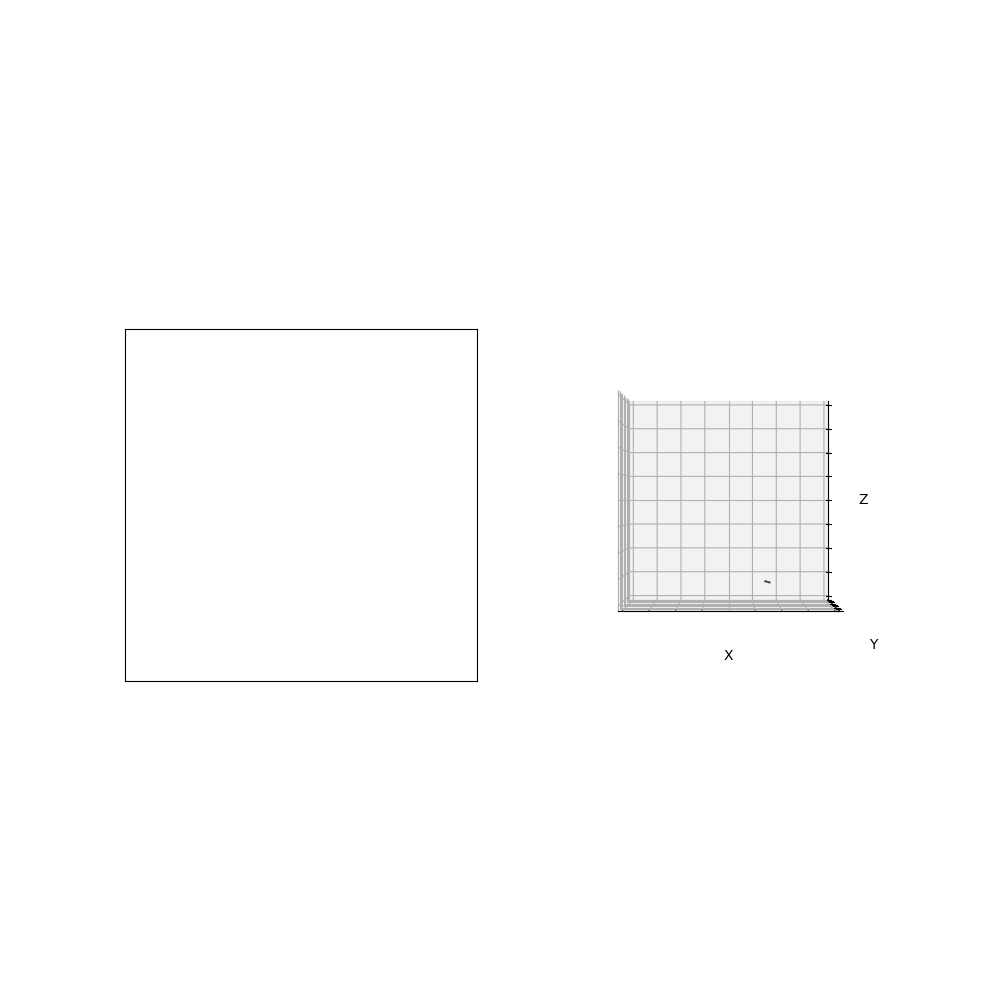

In [60]:
batch_num = 0
frame_num = 0
pred_vec = results_all_3d_pos[batch_num, frame_num]
gt_vec = gts_all_3d_pos[batch_num, frame_num]

%matplotlib widget
fig = plt.figure(1, figsize=(10, 10))
fig.clear()
fig.tight_layout()
ax = axes_2d(fig, loc=121, normalize=True, show_axis=False)
ax_3d = axes_3d(fig, loc=122, show_axis=False, xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(0, 90)) 
draw_3d_pose(ax_3d, pred_vec, dataset='vector')